In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
import seaborn as sns
from PIL import Image
import tensorflow.keras.backend as K
print(tf.__version__)
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from random import randint
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.svm import SVC
from keras.regularizers import l2
#print(device_lib.list_local_devices())

clean = True

## Folders Setup

In [ ]:
path = os.getcwd()
data = os.path.join(path,'data')

def folder_setup():
    """ works for linux only

    """
    df = pd.read_csv("train.csv")
    classes = df["label"].drop_duplicates().values.tolist()
    os.mkdir(os.path.join(path,'data'))
    
    # create classes folder
    for classe in classes :
        os.mkdir(os.path.join(path,'data',classe))

    # copy the image in the right classes folder
    for index, values in df.iterrows():
        os.system(f"cp {os.path.join(path,values[1])} {os.path.join(path,'data',values[2],values[1].split('/')[1])}")  

In [ ]:
#folder_setup()

## Classes and weights

In [ ]:
df = pd.read_csv("train.csv")
df_predictions = pd.read_csv("test_predictions.csv")
classes = sorted(df["label"].unique())
total = df["label"].size
weights = [1-count/total for count in df["label"].value_counts().sort_index()]
weights_classes = {}
for i,w in enumerate(weights):
    weights_classes[i] = w
classes

In [ ]:
images = []


for index,values in df.iterrows():
    img_path = os.path.join(path,'clean' if clean else 'train',values[1].split("/")[1])
    if not os.path.exists(img_path) :
        continue
    image = Image.open(img_path)

    images.append(
        {
            "path": img_path,
            "label": values[2],
            "width": image.width,
            "height": image.height,
        }
    )


train_data = pd.DataFrame.from_records(images)


In [ ]:
#train_data, test_data = train_test_split(
#    dataset, train_size=0.9, random_state=123, shuffle=True
#)

In [101]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_generator = ImageDataGenerator(
    #rescale=1.0 / 255,
    validation_split=0.10,
    #zoom_range=0.2,
    #rotation_range=20,
    #shear_range=0.2,
    #channel_shift_range=0.2,
    #fill_mode="nearest",
    #horizontal_flip=False,
)


## Create the dataset for training and validation

In [102]:
img_size = (256,256)
batch_size = 16

train_ds = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col="path",
    y_col="label",
    color_mode="rgb",
    class_mode="categorical",
    subset="training",
    batch_size=batch_size,
    target_size=img_size,
)

val_ds = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col="path",
    y_col="label",
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    batch_size=batch_size,
    target_size=img_size,
)

Found 1370 validated image filenames belonging to 19 classes.
Found 152 validated image filenames belonging to 19 classes.


## Display some images

In [ ]:
random_path = [Image.open(os.path.join(path,"train",str(randint(0,df["label"].size))+".jpg")) for i in range(9)]
fig, ax = plt.subplots(1,len(random_path),figsize=(40,40))
for num,img in enumerate(random_path):
    ax[num].imshow(img)
    ax[num].axis('off')

## Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import RandomFourierFeatures

### To keep the same shape everywhere

In [ ]:
keras.backend.set_image_data_format('channels_last')

### Transfer learning with EfficientNetB4 

In [103]:
from tensorflow.keras.applications import EfficientNetB4, ResNet50, VGG19
input_shape = (img_size[0],img_size[1],3)

# get efficientNetB4 layer
efficientNetB4 = EfficientNetB4(weights='imagenet', input_shape=input_shape, include_top=False)
resNet50 = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
vGG19 = VGG19(weights='imagenet', input_shape=input_shape, include_top=False)

# We dont want to change the weights from efficientNetB4
efficientNetB4.trainable = False
resNet50.trainable = False
vGG19.trainable = False

model_efficientNetB4 = Sequential([
    efficientNetB4,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(19, activation="softmax")
])

model_resNet50 = Sequential([
    resNet50,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(19, activation="softmax")
])

model_vGG19 = Sequential([
    vGG19,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(19, activation="softmax")
])

In [ ]:
model = Sequential([
    efficientNetB4,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(19, use_bias=False, activation='linear', name='svm')
])

In [ ]:
def svm_loss(layer):
    weights = layer.weights[0]
    weights_tf = tf.convert_to_tensor(weights)
    def categorical_hinge_loss(y_true, y_pred):
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1.0 - y_true) * y_pred, axis=-1)
        hinge_loss = K.mean(K.maximum(0.0, neg - pos + 1), axis=-1)
        regularization_loss = 0.5*(tf.reduce_sum(tf.square(weights_tf)))
        return regularization_loss + 0.4*hinge_loss  
    return categorical_hinge_loss

In [ ]:
#svclassifier = SVC(kernel='linear')
#svclassifier.fit(train_ds, val_ds)

### Simple model without any transfer learning

In [ ]:
Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(img_size[0],img_size[0],3), activation="relu"),
    Conv2D(32, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(64, (3,3), padding='same', activation="relu"),
    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(128, (3,3), padding='same', activation="relu"),
    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(256, (3,3), padding='same', activation="relu"),
    Conv2D(256, (3,3), activation="relu"),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(512, (3,3), padding='same', activation="relu"),
    Conv2D(512, (3,3), activation="relu"),
    
    Flatten(),
    Dense(256,activation="relu"),
    Dropout(0.2),
    Dense(19, activation="softmax")
])

### Display model summary

In [34]:
model_efficientNetB4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 8, 8, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1792)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 19)                34067     
Total params: 17,707,890
Trainable params: 34,067
Non-trainable params: 17,673,823
_________________________________________________________________


In [35]:
model_resNet50.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 19)                38931     
Total params: 23,626,643
Trainable params: 38,931
Non-trainable params: 23,587,712
_________________________________________________________________


In [37]:
model_vGG19.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 19)                9747      
Total params: 20,034,131
Trainable params: 9,747
Non-trainable params: 20,024,384
_________________________________________________________________


### Callbacks

#### Learning rates

In [104]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor=np.sqrt(0.1),
            patience=10,
            min_lr=0.5e-6)

#### Checkpoint and earlystopping

In [105]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stoping = EarlyStopping(
    monitor="val_accuracy",
    patience=15,
    restore_best_weights=True,
)


### Model compilation and training

In [91]:
models = [model_vGG19, model_efficientNetB4, model_resNet50][1:2]
files = ["vgg19.hdf5","efficientNetB4.hdf5","resNet50.hdf5"][1:2]
histories = []
for model, name in zip(models,files):
    checkpointer = ModelCheckpoint(filepath=name, verbose=1, save_best_only=True)
    model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    histories.append(model.fit(train_ds,
               epochs=150,
               validation_data=val_ds,
               callbacks=[reduce_lr,checkpointer, early_stoping],
               class_weight=weights_classes))

Epoch 1/150
77/77 [==============================] - 14s 111ms/step - loss: 0.5299 - accuracy: 0.8517 - val_loss: 1.3566 - val_accuracy: 0.5822

Epoch 00001: val_loss improved from inf to 1.35656, saving model to efficientNetB4.hdf5
Epoch 2/150
77/77 [==============================] - 7s 96ms/step - loss: 0.4385 - accuracy: 0.8901 - val_loss: 1.3448 - val_accuracy: 0.6053

Epoch 00002: val_loss improved from 1.35656 to 1.34481, saving model to efficientNetB4.hdf5
Epoch 3/150
77/77 [==============================] - 7s 97ms/step - loss: 0.3910 - accuracy: 0.9154 - val_loss: 1.3540 - val_accuracy: 0.6086

Epoch 00003: val_loss did not improve from 1.34481
Epoch 4/150
77/77 [==============================] - 7s 91ms/step - loss: 0.3563 - accuracy: 0.9229 - val_loss: 1.3653 - val_accuracy: 0.6086

Epoch 00004: val_loss did not improve from 1.34481
Epoch 5/150
77/77 [==============================] - 7s 90ms/step - loss: 0.3221 - accuracy: 0.9305 - val_loss: 1.3583 - val_accuracy: 0.6086

E

#### Model with SVM classifier

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001), 
    loss=svm_loss(model.get_layer('svm')), 
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds,
               epochs=150,
               validation_data=val_ds,
               callbacks=[reduce_lr,checkpointer, early_stoping],
               class_weight=weights_classes)

## Data visualization

### Some graphs of the history of training

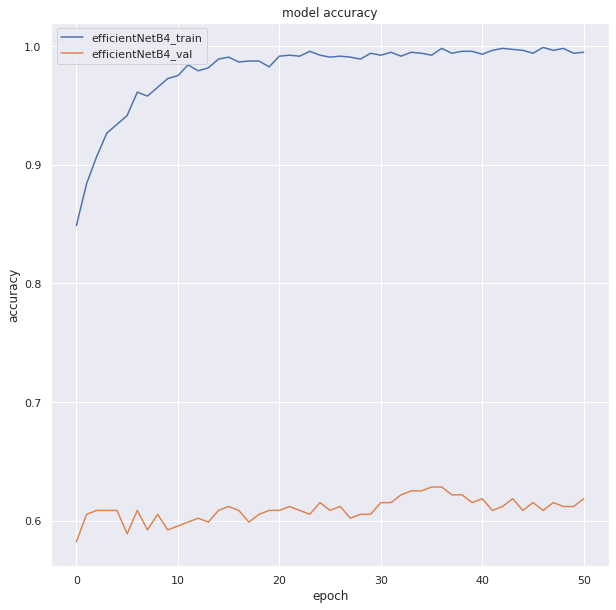

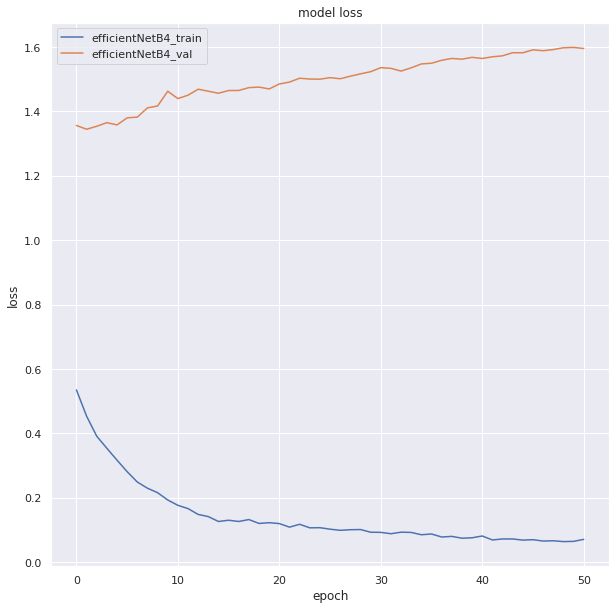

In [93]:
def plot_histories(histories,files):
    """
    Plot the loss & accuracy
    """
    plt.figure(figsize=[10,10])
    legend = []
    for history, name in zip(histories,files):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        legend.append(f'{name.split(".")[0]}_train')
        legend.append(f'{name.split(".")[0]}_val')
    plt.legend(legend, loc='upper left')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
    
    plt.figure(figsize=[10,10])
    legend = []
    for history, name in zip(histories,files):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        legend.append(f'{name.split(".")[0]}_train')
        legend.append(f'{name.split(".")[0]}_val')
    plt.legend(legend, loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_histories(histories,files)

In [106]:
def plot_history(history):
    """
    Plot the loss & accuracy
    """
    plt.figure(figsize=[10,10])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=[10,10])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history)

NameError: name 'history' is not defined

### Fine tunning

In [100]:
histories_fine_tunning = []
def unfreeze_model(model):
    for layer in model.layers[-6:]:
        # keep the normalisation trainable at False 
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True

for model, file in zip(models,files):
    checkpointer = ModelCheckpoint(filepath=file, verbose=1, save_best_only=True)
    unfreeze_model(model)
    model.compile(
        optimizer=keras.optimizers.Adam(lr=0.00001), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    histories_fine_tunning.append(model.fit(train_ds,
               epochs=10,
               validation_data=val_ds,
               callbacks=[reduce_lr,checkpointer],
               class_weight=weights_classes)),

Epoch 1/10
77/77 [==============================] - 39s 396ms/step - loss: 0.2146 - accuracy: 0.9661 - val_loss: 1.5398 - val_accuracy: 0.5691

Epoch 00001: val_loss improved from inf to 1.53976, saving model to efficientNetB4.hdf5
Epoch 2/10
77/77 [==============================] - 29s 376ms/step - loss: 0.2568 - accuracy: 0.9342 - val_loss: 1.5202 - val_accuracy: 0.5724

Epoch 00002: val_loss improved from 1.53976 to 1.52019, saving model to efficientNetB4.hdf5
Epoch 3/10
77/77 [==============================] - 29s 377ms/step - loss: 0.2109 - accuracy: 0.9476 - val_loss: 1.5062 - val_accuracy: 0.5888

Epoch 00003: val_loss improved from 1.52019 to 1.50619, saving model to efficientNetB4.hdf5
Epoch 4/10
77/77 [==============================] - 29s 378ms/step - loss: 0.1986 - accuracy: 0.9480 - val_loss: 1.5019 - val_accuracy: 0.5822

Epoch 00004: val_loss improved from 1.50619 to 1.50188, saving model to efficientNetB4.hdf5
Epoch 5/10
77/77 [==============================] - 28s 359m

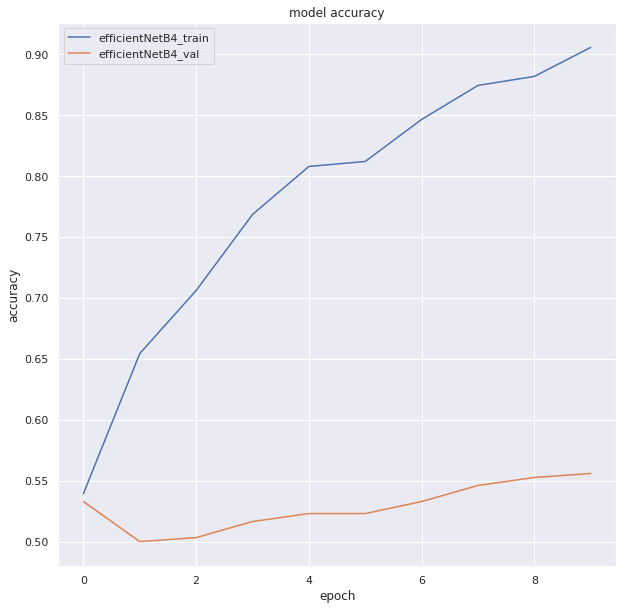

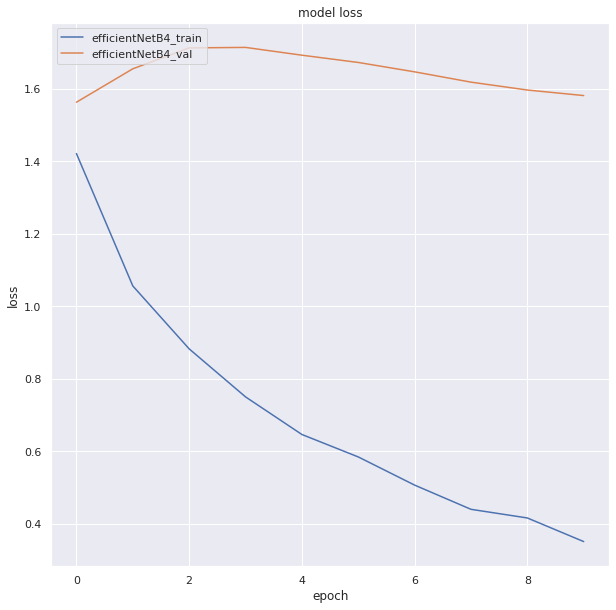

In [94]:
plot_histories(histories_fine_tunning,files)

In [ ]:


model.compile(
    optimizer=keras.optimizers.Adam(lr=0.00001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds,
               epochs=10,
               validation_data=val_ds,
               callbacks=[reduce_lr,checkpointer],
               class_weight=weights_classes)

In [ ]:
plot_history(history)

### Make a random prediction

In [ ]:
def do_prediction():
    # prediction
    model.load_weights('model.hdf5')
    from random import randint
    name_img = os.listdir(os.path.join(path,'test'))[randint(0,387)]
    random_path_img = os.path.join(path,'test',name_img)
    image_array = cv2.imread(random_path_img, cv2.IMREAD_COLOR) # Loading the image
    image_array = cv2.resize(image_array, (img_size[0], img_size[0])) # Resize the image
    #image = cv2.imread(random_path_img)
    #cv2.imshow('image',image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    scores = model.predict(np.array([image_array]))
    print(f'{name_img} -> {classes[scores.argmax(axis=-1)[0]]} {scores.max()}\n\n')
    for c,p in zip(classes,scores[0]):
        print(f'{c} prediction : {p}')





In [ ]:
efficientNetB4 = keras.models.load_model('efficientNetB4.hdf5')
vGG19 = keras.models.load_model('vgg19.hdf5')
resNet50 = keras.models.load_model('resNet50.hdf5')

In [90]:
weights_models = [max(h.history["val_accuracy"]) for h in histories_fine_tunning]
raw_valid_predictions = 0
for model, weight_model in zip(models, weights_models):
    raw_valid_predictions += 10000*weight_model*model.predict(val_ds)
#raw_valid_predictions = raw_valid_predictions/len(weights_models) 
valid_predicted_labels = raw_valid_predictions.argmax(axis=1)

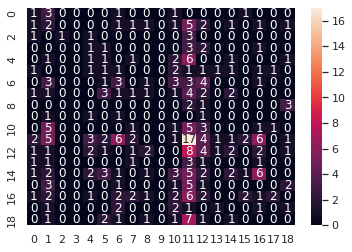

IndexError: string index out of range

In [89]:
cm = confusion_matrix(val_ds.classes, valid_predicted_labels)
sns.heatmap(cm, annot=True)
plt.show()
#for i,c in enumerate(classes):
#    print(f'{i} {c}')
df_list = []
for i in range(19):
    for j in range(19):
        if cm[i][j] >= 5 and i != j:
            df_list.append(pd.DataFrame({"classe_1":[f'{classes[i]} {i}'],"classe_2":[f'{classes[j]} {j}'],"value":[cm[i][j]]}))
pd.concat(df_list)

### Write output file test_predictions.csv

In [61]:
def test_predictions_avg():
    with open("test_predictions.csv","w") as file :
        images = []
        test_dir = os.listdir(os.path.join(path,'test'))
        file.write("index,path,pred\n")
        for img in test_dir:
            image_array = cv2.imread(os.path.join(path,'test',img), cv2.IMREAD_COLOR) # Loading the image
            images.append(cv2.resize(image_array, (img_size[0], img_size[0]))) # Resize the image
        scores_avg = 0
        for model, weight_model in zip(models, weights_models):
            scores_avg += weight_model*model.predict(np.array(images))
        scores_avg = raw_valid_predictions/len(weights_models) 
        for s,img in zip(scores_avg.argmax(axis=-1),test_dir) :
            classe = classes[s]
            file.write(f"{img.split('.')[0]},train/{img},{classe}\n")

        
test_predictions_avg()


In [ ]:
def test_predictions():
    model = keras.models.load_model('model.hdf5')
    with open("test_predictions.csv","w") as file :
        images = []
        test_dir = os.listdir(os.path.join(path,'test'))
        file.write("index,path,pred\n")
        for img in test_dir:
            image_array = cv2.imread(os.path.join(path,'test',img), cv2.IMREAD_COLOR) # Loading the image
            images.append(cv2.resize(image_array, (img_size[0], img_size[0]))) # Resize the image
        scores = model.predict(np.array(images))
        for s,img in zip(scores.argmax(axis=-1),test_dir) :
            classe = classes[s]
            file.write(f"{img.split('.')[0]},train/{img},{classe}\n")

        
test_predictions()


### classes analysis

In [63]:


sns.set()

In [64]:
images = []

for classes in os.listdir(os.path.join(path,'data')):
    for img in os.listdir(os.path.join(path,'data',classes)):
        img_path = os.path.join(path,'data',classes,img)
        image = Image.open(img_path)

        images.append(
            {
                "path": img_path,
                "label": classes,
                "width": image.width,
                "height": image.height,
            }
        )


dataset = pd.DataFrame.from_records(images)

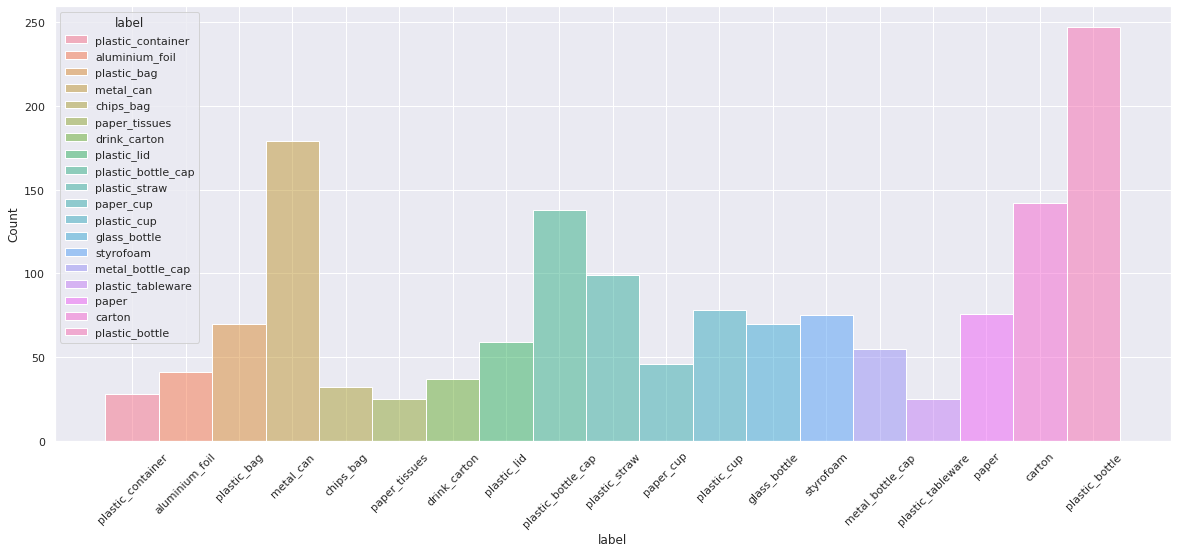

In [65]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=45)
ax = sns.histplot(data=dataset, x="label", hue="label")


<AxesSubplot:xlabel='width', ylabel='height'>

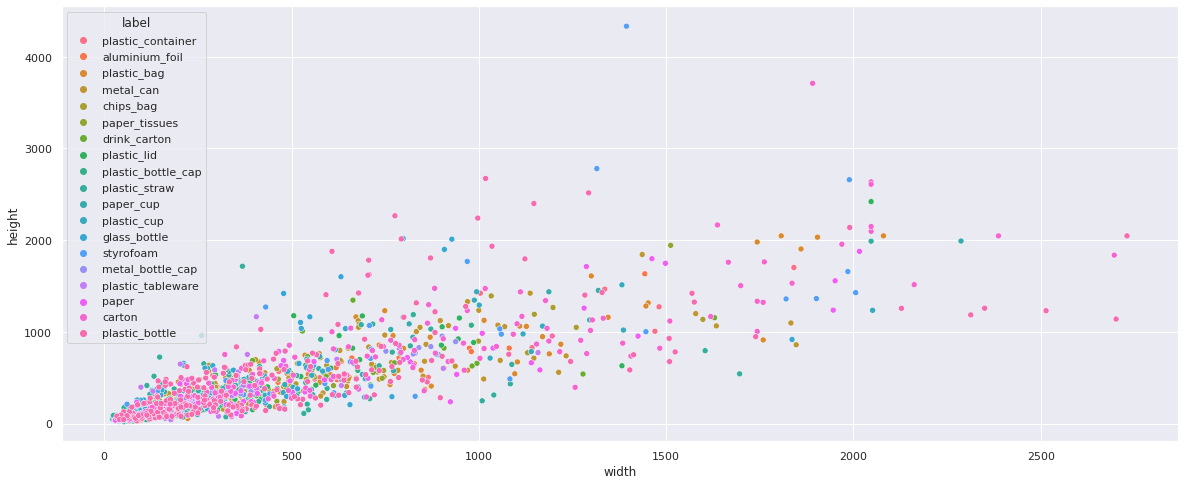

In [66]:
plt.figure(figsize=(20,8))
sns.scatterplot(data=dataset, x="width", y="height", hue="label")

<AxesSubplot:xlabel='aspect_ratio', ylabel='Count'>

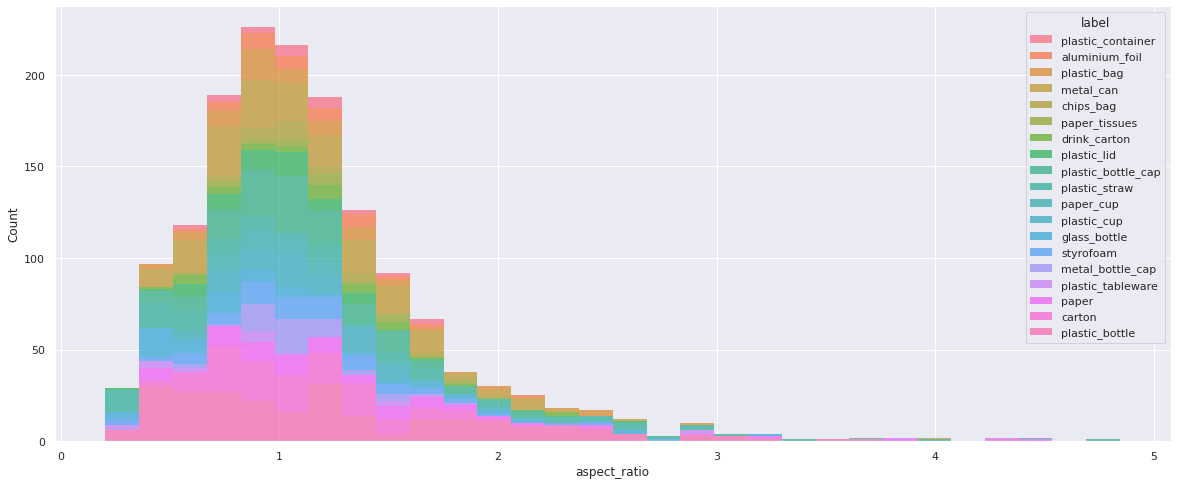

In [67]:
dataset["aspect_ratio"] = dataset.width / dataset.height
plt.figure(figsize=(20,8))
sns.histplot(
    data=dataset, x="aspect_ratio", hue="label", bins=30, multiple="stack", linewidth=0
)

<AxesSubplot:xlabel='resolution', ylabel='Count'>

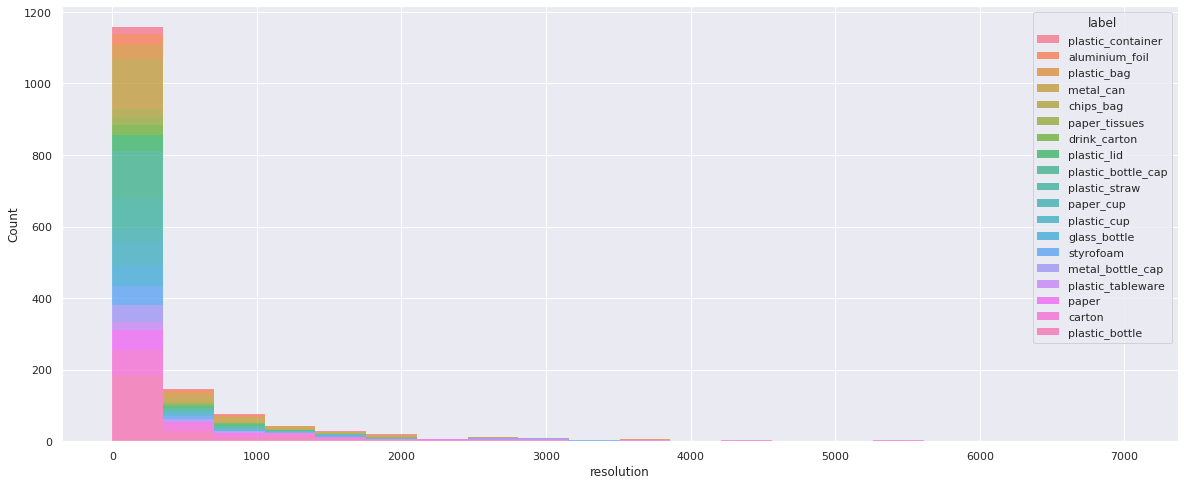

In [68]:
dataset["resolution"] = (dataset.width * dataset.height) / 1_000
plt.figure(figsize=(20,8))
sns.histplot(
    data=dataset, x="resolution", hue="label", bins=20, multiple="stack", linewidth=0
)